### Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib
%matplotlib inline
import folium

### Loading data

In [2]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'
POPULATION_FILE = 'population.csv'
IHD_FILE = 'ihd.csv'
JSON_COUNTRIES_FILE = 'world-countries.json'

In [143]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)
ihd = pd.read_csv(DATA_FOLDER + '/' + IHD_FILE, low_memory=False)
population = pd.read_csv(DATA_FOLDER + '/' + POPULATION_FILE, low_memory=False)
countries_shapes = pd.read_json(DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, orient='columns')

### Analysis of the different fields available in the dataset

We have to select only the features which is possible to help us to answer our questions

In [4]:
for col in all_datas.columns.values:
    print("- ", col)

-  code
-  url
-  creator
-  created_t
-  created_datetime
-  last_modified_t
-  last_modified_datetime
-  product_name
-  generic_name
-  quantity
-  packaging
-  packaging_tags
-  brands
-  brands_tags
-  categories
-  categories_tags
-  categories_en
-  origins
-  origins_tags
-  manufacturing_places
-  manufacturing_places_tags
-  labels
-  labels_tags
-  labels_en
-  emb_codes
-  emb_codes_tags
-  first_packaging_code_geo
-  cities
-  cities_tags
-  purchase_places
-  stores
-  countries
-  countries_tags
-  countries_en
-  ingredients_text
-  allergens
-  allergens_en
-  traces
-  traces_tags
-  traces_en
-  serving_size
-  serving_quantity
-  no_nutriments
-  additives_n
-  additives
-  additives_tags
-  additives_en
-  ingredients_from_palm_oil_n
-  ingredients_from_palm_oil
-  ingredients_from_palm_oil_tags
-  ingredients_that_may_be_from_palm_oil_n
-  ingredients_that_may_be_from_palm_oil
-  ingredients_that_may_be_from_palm_oil_tags
-  nutrition_grade_uk
-  nutrition_grade_f

We can deduce the usefull colums for our project:
 - product_name
 - sugars_100g
 - fat_100g
 - nutrition_grade_fr
 - countries
 - countries_tags


### Datasets clean
We clean our datasets. We select only the potential interesting fields. 

We do some operations on the countries tags to be able to parse the data. We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics :-p 

In [5]:
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME', 'COUNTRY_ALPHA3_CODE']]

In [6]:
usefull_datas = all_datas.copy()
to_keep = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g','serving_quantity','energy_100g',
           'carbohydrates_100g','proteins_100g','salt_100g','sodium_100g','saturated-fat_100g',
           'ingredients_text', 'additives',  'fiber_100g','serving_size', 'additives_en']
usefull_datas = usefull_datas[to_keep]

#only do this for full na set
#usefull_datas.dropna(inplace=True)
usefull_datas['countries_tags'] = usefull_datas['countries_tags'].replace(regex=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'-', value=r' ')
usefull_datas['countries'] = usefull_datas['countries'].apply(lambda x: str(x).lower())
usefull_datas = usefull_datas[usefull_datas['sugars_100g'] <= 100]
usefull_datas = usefull_datas[usefull_datas['fat_100g'] <= 100]
#get a feel of the data
usefull_datas.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en
0,Vitória crackers,france,france,15.0,7.0,0,1569.0,70.1,7.8,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN
2,Sauce Sweety chili 0%,france,france,0.4,0.0,0,88.0,4.8,0.2,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN
4,Salade de carottes râpées,france,france,3.9,0.3,0,134.0,5.3,0.9,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN
5,Fromage blanc aux myrtilles,france,france,16.3,4.9,0,540.0,16.3,4.4,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN
8,Baguette parisien,france,france,1.8,3.3,0,929.0,38.4,11.7,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN


We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [7]:

countries = []

for c in usefull_datas['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.lower()
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name and country code
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [8]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)

In [9]:
to_append = [('united-states', 'US'), ('united-kingdom', 'UK'), ('french-polynesia', 'PF'),
             ('hong-kong', 'HK'), ('new-zealand', 'NZ'), ('new-caledonia', 'NC'),
             ('scotland','GB'), ('united-arab-emirates', 'AE'), ('etats-unis', 'US'),
             ('czech-republic', 'CZ'), ('south-africa', 'ZA'), ('quebec', 'CA'), 
             ('saint-pierre-and-miquelon', 'FR'),('french-guiana', 'FR'), ('dom-tom', 'FR'), ('south-korea', 'KR')]
for i in to_append:
    proper_countries.append(i)

In [10]:
proper_countries

[('france', 'FR'),
 ('canada', 'CA'),
 ('oman', 'OM'),
 ('germany', 'DE'),
 ('belgium', 'BE'),
 ('netherlands', 'NL'),
 ('mexico', 'MX'),
 ('australia', 'AU'),
 ('switzerland', 'CH'),
 ('egypt', 'EG'),
 ('italy', 'IT'),
 ('spain', 'ES'),
 ('saudi-arabia', 'SA'),
 ('iraq', 'IQ'),
 ('sverige', 'SE'),
 ('sweden', 'SE'),
 ('vietnam', 'VN'),
 ('singapore', 'SG'),
 ('thailand', 'TH'),
 ('greece', 'GR'),
 ('panama', 'PA'),
 ('malaysia', 'MY'),
 ('luxembourg', 'LU'),
 ('lebanon', 'LB'),
 ('denmark', 'DK'),
 ('guyana', 'GY'),
 ('serbia', 'RS'),
 ('martinique', 'MQ'),
 ('barbados', 'BB'),
 ('ireland', 'IE'),
 ('aruba', 'AW'),
 ('bahrain', 'BH'),
 ('taiwan', 'TW'),
 ('cuba', 'CU'),
 ('portugal', 'PT'),
 ('kuwait', 'KW'),
 ('austria', 'AT'),
 ('japan', 'JP'),
 ('israel', 'IL'),
 ('royaume-uni', 'GB'),
 ('brazil', 'BR'),
 ('morocco', 'MA'),
 ('guinea', 'GN'),
 ('china', 'CN'),
 ('algeria', 'DZ'),
 ('mauritius', 'MU'),
 ('indonesia', 'ID'),
 ('turkey', 'TR'),
 ('belgien', 'BE'),
 ('deutschland', 'DE

When a rows mention many countries we explode the dataframe to get one line for each country.

In [11]:
def explode(df):
    rows = []
    for index, data in df.iterrows():
        countries = str(data['countries_tags']).split(',')
        for country in countries:
            data['countries'] = country
            rows.append(data)
    return pd.DataFrame(rows)

In [12]:
exploded_data = explode(usefull_datas)

In [29]:
def get_tag(row, col1, col2):
    for c in proper_countries:
        if c[0] == row[col1]:
            row[col2] = c[1]
            return row
    row[col2] = "TBD"
    return row


In [30]:
parsed_datas = exploded_data.apply(lambda x: get_tag(x, 'countries', 'countries_tags'), axis=1)

In [31]:
parsed_datas[parsed_datas['countries_tags'] == 'TBD']['countries']

16164                     nan
18679                     nan
28022                     nan
29679                     nan
39487                      en
39487                      en
39656                      en
39656                      en
39656                      en
60736                      en
60736                      en
60738                      en
60738                      en
62077                     nan
66242                     nan
67677          estadps-unidos
67677          estadps-unidos
71979                     nan
72989                     nan
74551                     nan
76487                     nan
76636                 pour-la
76636                 pour-la
76636                 pour-la
109135                     en
109135                     en
112565                    nan
116080         european-union
117296                     en
117296                     en
                 ...         
677796                     en
679017                     en
679017    

In [32]:
parsed_datas[parsed_datas['countries_tags'] == 'TBD']['countries'].value_counts()

en                                     645
nan                                    127
reino-unido                             13
vereinigtes-konigreich                  13
suede                                   10
european-union                          10
republic-of-macedonia                    9
grece                                    8
europe                                   8
republic-of-the-congo                    7
verenigd-koninkrijk                      7
franca                                   6
carrefour                                5
tahiti                                   5
cote-d-ivoire                            5
polyensie-francaise                      5
magyarorszag                             5
world                                    4
england                                  4
česko                                    4
ran                                      4
صنعاء                                    4
rumanien                                 4
costa-rica 

In [33]:
parsed_datas['countries_tags'].value_counts()

FR     360855
US     162820
CH      19013
DE      13916
ES       6635
UK       6297
IT       2035
MX       1524
BE       1421
SE       1271
NL       1194
TBD      1009
PT        911
CA        775
AU        678
RS        595
RO        587
RE        531
IE        433
LU        415
GP        402
HU        371
PF        361
MQ        276
MA        275
NC        230
PL        203
RU        199
NZ        187
TN        173
        ...  
MR          5
SZ          4
ME          4
AL          4
VE          4
VU          4
EE          3
IQ          3
AZ          3
GN          3
MO          3
KE          3
PK          3
TG          2
ML          2
MD          2
MZ          2
LY          2
EC          2
NG          2
PA          2
CM          2
FJ          2
NE          2
HR          2
DM          1
GI          1
HT          1
GT          1
AW          1
Name: countries_tags, Length: 120, dtype: int64

### Get results
Now we compute result from the parsed datasets. We would like to get the mean average of sugar and fat per 100g per country.

In [34]:
grouped = parsed_datas.groupby(['countries_tags'])
means = grouped.mean()
means

,sugars_100g,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g
countries_tags,,,,,,,,,
AD,1.708000,6.512000,765.260000,19.920000,9.618000,0.964800,0.379850,2.617800,7.060000
AE,24.628485,15.450000,1384.106061,39.059385,7.841875,2.103947,0.828316,6.596970,5.310811
AL,8.925000,3.900000,605.250000,23.100000,3.750000,0.711250,0.280020,1.700000,0.000000
AR,25.568333,17.087222,1436.055556,41.694444,7.921111,0.453892,0.178870,6.327056,1.392667
AT,8.527550,14.451258,1043.470199,22.974800,6.963067,1.789607,0.704542,5.406918,2.953333
AU,12.672323,10.883420,974.551374,25.090659,7.110261,2.216563,0.872492,4.482342,4.113697
AW,8.000000,17.300000,2000.000000,70.000000,8.000000,1.770380,0.697000,8.000000,1.400000
AZ,0.000000,0.200000,738.666667,72.000000,0.000000,0.010000,0.003937,0.000000,0.000000
BE,12.409372,14.409027,1153.605835,28.195560,10.358676,1.162647,0.457731,4.987731,2.816753


In [35]:
grouped = parsed_datas.groupby(['countries_tags'])
counted = grouped.count()

In [36]:
sugar = means[['sugars_100g']].dropna()
#remove outliers
sugar = sugar[sugar['sugars_100g'] <= 100]
#we would like to have countries with a big enough sample of values in the database, we choose 20 for now
sugar = sugar[counted['sugars_100g'] > 20]
#sort values
sugar.sort_values(by=['sugars_100g'], ascending=False, inplace=True)

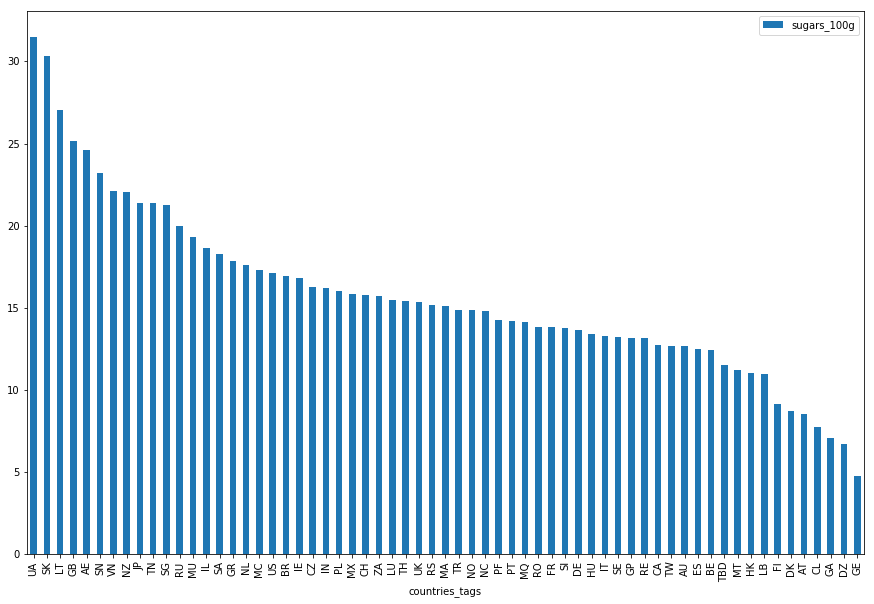

In [37]:
sugar.plot.bar(figsize=(15,10))

We can see which countries consume the most sugars according to our datas.

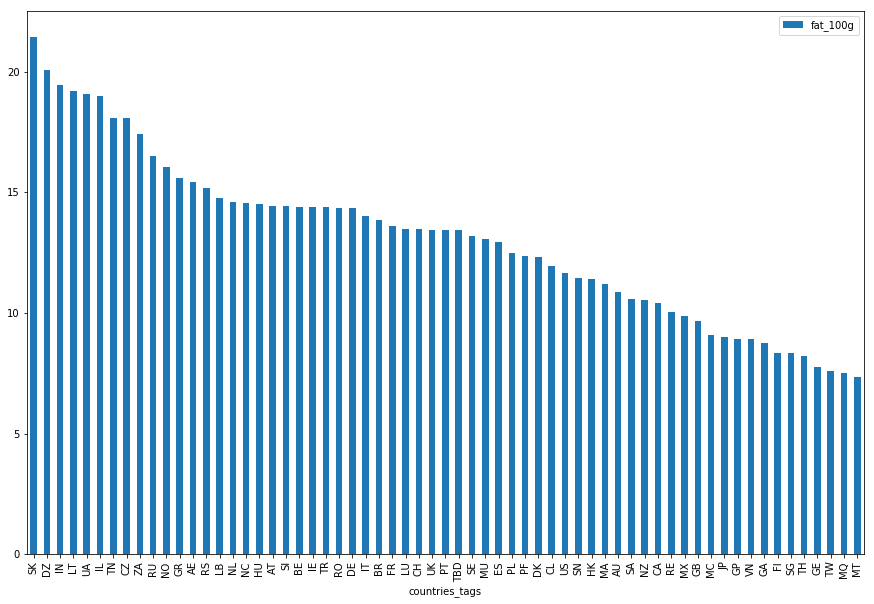

In [38]:
#remove null values
fat = means[['fat_100g']].dropna()
#remove outliers
fat = fat[fat['fat_100g'] <= 100]
#remove values with small sample
fat = fat[counted['fat_100g'] > 20]
#sort
fat.sort_values(by=['fat_100g'], ascending=False, inplace=True)
fat.plot.bar(figsize=(15,10))

In [39]:
def corr_scatter(df1, df2, merge_on, x_, y_, title_):
    merge = pd.merge(df1, df2, on=merge_on)
    merge.plot(kind='scatter',x=x_,y=y_, title=title_)
    print('Pearson correlation: ', merge.corr(method='pearson').iloc[0][1])
    print('Kendall correlation: ', merge.corr(method='kendall').iloc[0][1])
    print('Spearman correlation: ', merge.corr(method='spearman').iloc[0][1])

Pearson correlation:  0.31988384134014386
Kendall correlation:  0.18177163338453656
Spearman correlation:  0.24870391705069125


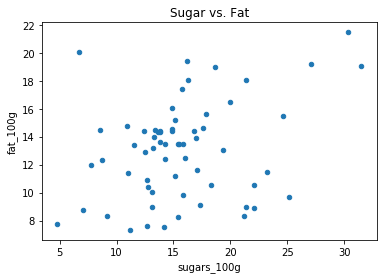

In [40]:
corr_scatter(sugar, fat, 'countries_tags', 'sugars_100g', 'fat_100g', 'Sugar vs. Fat')

We can see which countries consume the most fat according to our datas. 
We can guess some correlations, for instance (Slovakia are on the top of the ranking for each aspect) and some independant values (Germany use a lot of fat but not so much sugar), but we would need to calculate to be sure (next milestone)

We get the union of the sugar and fat datas to filter some other results.

In [41]:
indexes = pd.DataFrame(np.concatenate((sugar.index.values,fat.index.values)))
indexes = indexes.drop_duplicates()

In [76]:
indexes.head()

,0
0,UA
1,SK
2,LT
3,GB
4,AE


In [101]:
overweight.head()

,Entity,Code,Year,Indicator
0,Afghanistan,AFG,1975,0.5
1,Afghanistan,AFG,1976,0.5
2,Afghanistan,AFG,1977,0.6
3,Afghanistan,AFG,1978,0.6
4,Afghanistan,AFG,1979,0.6


In [102]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: x.lower().replace(' ', '-'))

In [103]:
#get country codes
overweight_datas = overweight_datas.apply(lambda x: get_tag(x, 'Entity', 'Code'), axis=1)

In [104]:
overweight_datas.head()

,Entity,Code,Year,Indicator
41,afghanistan,AF,2016,5.5
83,albania,AL,2016,21.7
125,algeria,DZ,2016,27.4
167,andorra,AD,2016,25.6
209,angola,TBD,2016,8.2


In [105]:
#overweight_datas[overweight_datas['Code'] == 'TBD']['Entity']

In [106]:
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Code'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Code'])
overweight_datas

,Entity,Year,Indicator
Code,,,
AF,afghanistan,2016,5.5
AL,albania,2016,21.7
DZ,algeria,2016,27.4
AD,andorra,2016,25.6
AR,argentina,2016,28.3
AM,armenia,2016,20.2
AU,australia,2016,29.0
AT,austria,2016,20.1
AZ,azerbaijan,2016,19.9


In [107]:
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]

In [108]:
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)

In [109]:
overweight_datas.head()

,Indicator
Code,
KW,37.9
US,36.2
JO,35.5
SA,35.4
QA,35.1


In [110]:
overweight_datas = overweight_datas[overweight_datas.index.isin(indexes[0])]

In [111]:
overweight_datas

,Indicator
Code,
US,36.2
SA,35.4
TR,32.1
LB,32.0
AE,31.7
NZ,30.8
CA,29.4
AU,29.0
MT,28.9


In [112]:
overweight_datas = overweight_datas.rename(columns={'Indicator':'Overweight Prevalence'})
overweight_datas.index.name = 'countries_tags'

In [113]:
overweight_datas

,Overweight Prevalence
countries_tags,
US,36.2
SA,35.4
TR,32.1
LB,32.0
AE,31.7
NZ,30.8
CA,29.4
AU,29.0
MT,28.9


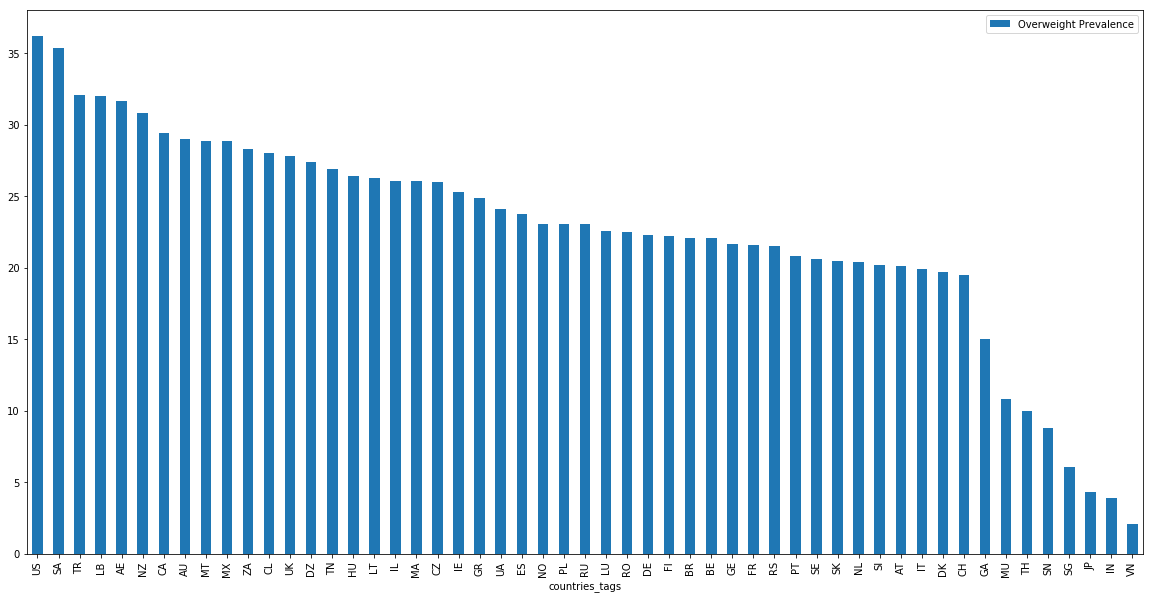

In [114]:
overweight_datas.plot.bar(figsize=(20,10))

Pearson correlation:  0.1877450836681874
Kendall correlation:  0.10618207091299847
Spearman correlation:  0.12612649064130013


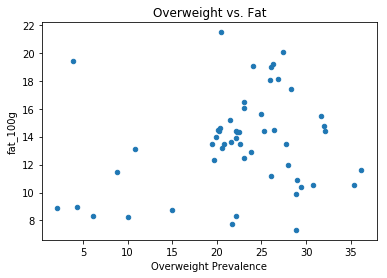

In [115]:
corr_scatter(fat, overweight_datas,'countries_tags', 'Overweight Prevalence', 'fat_100g', 'Overweight vs. Fat')

Pearson correlation:  -0.1365472920393349
Kendall correlation:  -0.01745458699939701
Spearman correlation:  -0.04479748436780193


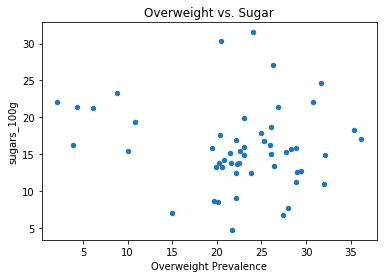

In [116]:
corr_scatter(sugar, overweight_datas,'countries_tags', 'Overweight Prevalence', 'sugars_100g', 'Overweight vs. Sugar')

As we can see : It is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the obesity percentage displayed above. 
For example the slovakia is in the mean (for the obesity) but not really for the sugar & fat. That is only a guess we have to provide a scatter plot to proove it.

In [124]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])

In [125]:
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: str(x).lower().replace(' ', '-'))
diab = diab.apply(lambda x: get_tag(x, 'country/territory', 'code'), axis=1)

diab

,country/territory,Diabetes [18-99] national prevalence[%],code
0,afghanistan,6.15,AF
1,albania,11.93,AL
2,algeria,6.88,DZ
3,andorra,12.70,AD
4,angola,2.92,TBD
5,anguilla,12.80,TBD
6,antigua-and-barbuda,13.40,TBD
7,argentina,5.82,AR
8,armenia,7.56,AM
9,aruba,14.25,AW


In [130]:
# TODO fix this
diab[diab['code'] == 'TBD'][40:]

,country/territory,Diabetes [18-99] national prevalence[%],code
104,kyrgyzstan,6.05,TBD
105,lao-people's-democratic-republic,2.81,TBD
108,lesotho,2.48,TBD
109,liberia,1.83,TBD
114,macedonia,12.14,TBD
118,maldives,7.46,TBD
121,marshall-islands,31.38,TBD
126,federated-states-of-micronesia,10.13,TBD
133,myanmar,3.84,TBD
135,nauru,22.89,TBD


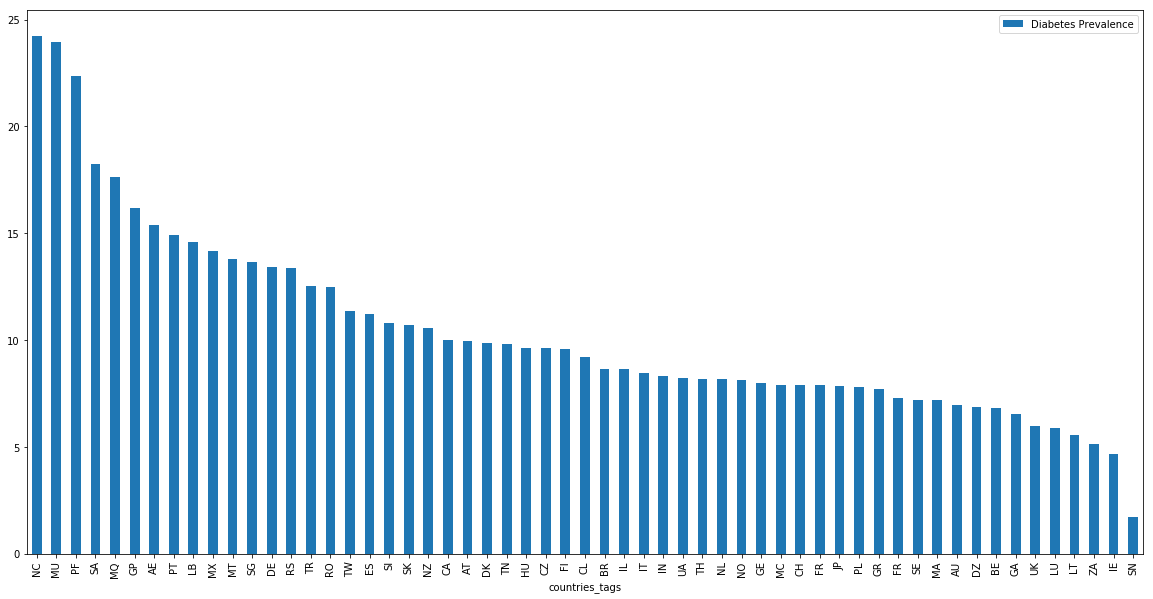

In [131]:

#remove rows without country codes
diab = diab[diab['code'] != 'TBD']
#set index for more agreable plotting
diab.set_index('code', inplace=True)
diab = diab[diab.index.isin(indexes[0])]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab = diab.rename(columns={'Diabetes [18-99] national prevalence[%]':'Diabetes Prevalence'})
diab.index.name = 'countries_tags'
diab.plot.bar(figsize=(20,10))

Pearson correlation:  -0.16965975852814563
Kendall correlation:  -0.09714823416553571
Spearman correlation:  -0.15076728624105198


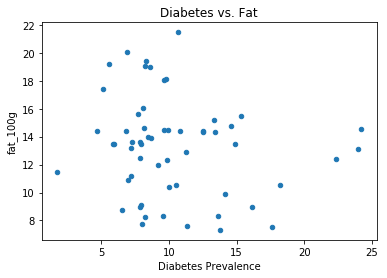

In [132]:
corr_scatter(fat, diab,'countries_tags', 'Diabetes Prevalence', 'fat_100g', 'Diabetes vs. Fat')

Pearson correlation:  -0.01068612050853973
Kendall correlation:  -0.009401442016019584
Spearman correlation:  -0.045956150449228655


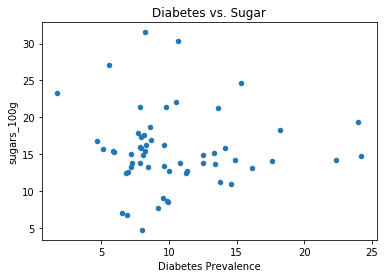

In [133]:
corr_scatter(sugar, diab,'countries_tags', 'Diabetes Prevalence', 'sugars_100g', 'Diabetes vs. Sugar')

Pearson correlation:  0.11701412021755189
Kendall correlation:  0.1005895850905357
Spearman correlation:  0.14092091955781672


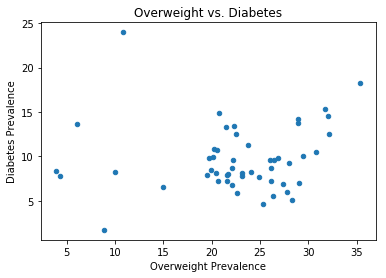

In [134]:
corr_scatter(overweight_datas, diab,'countries_tags', 'Overweight Prevalence', 'Diabetes Prevalence', 'Overweight vs. Diabetes')

Like for the obesity : it is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the diabetes percentage display above. Same example : slovakia is in just after the middle but not really for the sugar & fat. Once more that is only a guess we have to provide a scatter plot to proove it.

### Summarize
We selected the datas who have an interest for us. We parse them to be able to get some results from it. We already get some results concerning alimentation quality of different countries. The really next step is to prove if a correlation exists between our results. (We have some guesses, but we have to provide a scatter plot and a correlation coefficient to proove it)

### What comes next

First, we reoriented our approach of our study. 
We decided to globalize our approach and not to focus our work only on the european countries. 
Indeed not too many countries have relevant data so we can include all of them.

We spent a lot of time on cleaning the datasets, so we focused our milestone on the countries part. 
We now will be able to have more relevant results, such as a visualization of the correlation (or not) between features.
We will focus on the food quality in the next steps, such as finding which particular foods have a higher sugar or fat content, instead of just comparing the countries. 

#### Research questions 
As we discussed above we did not yet work on the food quality, so we are not able to answer our research questions for the moment. We have to extract more data and try to find a correlation with the ones we already have. 

### IHD 

In [144]:
ihd_df = ihd.copy()
ihd['IHD'] = ihd['IHD'].apply(lambda x: x*1000)
ihd['Country'] = ihd['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
ihd = ihd.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
ihd = ihd[ihd['code'] != 'TBD']
ihd = ihd.set_index(['code'])
ihd.head()

,Country,IHD
code,,
DE,germany,155800.0
JP,japan,105500.0
UK,united-kingdom,92300.0
IT,italy,87800.0
PL,poland,79000.0


In [145]:
population['Country'] = population['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
population = population.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
population = population[population['code'] != 'TBD']
population = population.set_index(['code'])
population.head()

,Country,Population
code,,
CN,china,1321851888
IN,india,1129866154
US,united-states,301139947
ID,indonesia,234693997
BR,brazil,190010647


In [159]:
pop_ihd = ihd.merge(population, left_index=True, right_index=True)
pop_ihd.drop(columns=['Country_y'], inplace=True)
pop_ihd['IHD_%'] = ""

In [161]:
#for index, data in pop_ihd.iterrows():
#    data['IHD_%'] = data['IHD'] / data['Population'] * 100
    
def find_percentage(row):
    row['IHD_%'] =  row['IHD'] / row['Population'] * 100
    return row

pop_ihd = pop_ihd.apply(find_percentage, axis=1)
pop_ihd

,Country_x,IHD,Population,IHD_%
code,,,,
AE,united-arab-emirates,1200.0,4444011,0.027003
AF,afghanistan,30900.0,31889923,0.096896
AL,albania,5400.0,3600523,0.149978
AM,armenia,10500.0,2971650,0.353339
AR,argentina,36400.0,40301927,0.090318
AT,austria,14600.0,8199783,0.178053
AU,australia,24900.0,20434176,0.121855
AZ,azerbaijan,16300.0,8120247,0.200733
BB,barbados,200.0,280946,0.071188


In [162]:
def from_2_to_3_country_code(country_tag_2):
    code = countries_infos[countries_infos['COUNTRY_ALPHA2_CODE'] == country_tag_2]['COUNTRY_ALPHA3_CODE'].drop_duplicates()
    if code.size != 1:
        return 'TBD'
    else:
        return code.iloc[0]

In [163]:
def get_code_from_json(json_object):
    found = re.search('.id.\s*:\s*.(\w\w\w).', json_object, re.IGNORECASE)  
    #print(json_object)
    if found:
        json_object = found.group(1)
    return json_object

In [166]:
def get_map():
    #countries_infos
    sugar_for_map = sugar.reset_index()
    sugar_for_map['countries_tags'] = sugar_for_map['countries_tags'].apply(lambda x: from_2_to_3_country_code(x))
    sugar_for_map
    
    countries_shapes['features'] = countries_shapes['features'].apply(lambda x: get_code_from_json(str(x)))

    for code in countries_shapes['features']:
        if len(code) != 3:
            continue

        if sugar_for_map[sugar_for_map['countries_tags'] == code].size == 0:
            test = pd.DataFrame(columns=['countries_tags', "sugars_100g"])
            
            dTest = {
                'countries_tags' : code,
                'sugars_100g' : 0
            }
            
            sugar_for_map = sugar_for_map.append(dTest, ignore_index=True)
            
        
            
    # Setup a folium map at a high-level zoom
    map = folium.Map(location=[30, 0], zoom_start=2)

    # choropleth maps bind Pandas Data Frames and json geometries.
    #This allows us to quickly visualize data combinations
    map.choropleth(geo_data=DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, data=sugar_for_map,
                 columns=['countries_tags', 'sugars_100g'],
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name='hist_indicator')
    return map

In [167]:
sugar_map = get_map()

In [168]:
sugar_map

### Playground

In [ ]:
data = all_datas.copy()
data['countries_tags'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
data = data[data['sugars_100g'] <= 100]
data = data[data['fat_100g'] <= 100]

In [ ]:
not_na = []
for c in data.columns.values: 
    count = data[c].notna().sum()
    not_na.append((c, count))
df = pd.DataFrame(not_na, columns=['Name','Not_NA_Count'])
df.sort_values(by='Not_NA_Count', inplace=True, ascending=False)
df = df.reset_index(drop=True)
df.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,10))

In [ ]:
df_2 = df[df['Not_NA_Count'] > 10000]
df_2.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,10))

In [ ]:
to_keep = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
           'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_that_may_be_from_palm_oil_n',
           'ingredients_text','ingredients_from_palm_oil_n', 'additives_n','additives','fiber_100g','serving_size',
           'additives_en','additives_tags','calcium_100g','vitamin-c_100g','cholesterol_100g',
           'iron_100g','trans-fat_100g','vitamin-a_100g','allergens','traces_en',
           'manufacturing_places','potassium_100g','vitamin-b1_100g','vitamin-b2_100g']

to_keep_red = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
           'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_that_may_be_from_palm_oil_n',
           'ingredients_text','ingredients_from_palm_oil_n', 'additives_n','additives','fiber_100g','serving_size',
           'additives_en']

to_keep_red_2 = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
                 'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_text', 'additives',
                 'fiber_100g','serving_size', 'additives_en']

In [ ]:
data = data[to_keep_red_2]
data

In [ ]:
parsed_datas.sort_values(by='sugars_100g', ascending=False)[0:100]